In [5]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from PIL import Image
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip drive/MyDrive/archive_labels.zip

In [7]:
df = pd.read_csv('archive/dataset/edited_data.csv')
df.columns.tolist()

['Latitude', 'Longitude', 'Country', 'Continent', 'Continent_Label']

In [8]:
# Loading the image file name inside a list.
image_folder = 'archive/dataset/'
image_files = [file for file in os.listdir(image_folder) if file.endswith('.png')]
image_files = sorted(image_files, key=lambda x: int(os.path.splitext(x)[0]))

In [9]:
# Match the image file names with their corresponding coordinates
image_labels = []
for image_file in image_files:
    image_number = int(os.path.splitext(image_file)[0])
    image_label = df.loc[image_number, 'Continent_Label']  # Extract only the 'Continent_Label' from the DataFrame
    image_labels.append(image_label)
print(image_labels[990])
print(image_files[990])

1
990.png


In [10]:
# Splitting the dataset into train, validation and test
train_files, testval_files, train_labels, testval_labels = train_test_split(image_files, image_labels, test_size=0.3, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(testval_files, testval_labels, test_size=0.5, random_state=42)

# Check if coordinates match for train, test and validation sets.
print(train_files[40])
print(train_labels[40])

2354.png
4


In [11]:
# CustomDataset class to load images and continent labels
class CustomDataset(Dataset):
    def __init__(self, image_folder, image_files, labels, transform=None):
        self.image_folder = image_folder
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_folder, image_file)
        image = Image.open(image_path)

        continent_label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, continent_label

In [12]:
# Preprocessing transforms
preprocess = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
# Creating dataset instances
train_dataset = CustomDataset(image_folder, train_files, train_labels, transform=preprocess)
val_dataset = CustomDataset(image_folder, val_files, val_labels, transform=preprocess)
test_dataset = CustomDataset(image_folder, test_files, test_labels, transform=preprocess)

In [14]:
# Assuming you have already created the train_dataset
sample_index = 50
image_tensor, continent_label = train_dataset[sample_index]

# Now you can check the contents of the image tensor and the continent label
print("Image tensor shape:", image_tensor.shape)
print("Continent label:", continent_label)

Image tensor shape: torch.Size([3, 64, 64])
Continent label: 4


In [21]:
# DataLoader settings
batch_size = 32
num_workers = 2
num_classes = 6
alpha = 0.005
num_epochs = 30
num_folds = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.fc_layers = nn.Sequential(
#             nn.Linear(64 * 32 * 32, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#         )

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc_layers(x)
#         return x

# import torch.nn.functional as F
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 64x64x3 -> 64x64x16
#         self.pool = nn.MaxPool2d(2, 2)  # 64x64x16 -> 32x32x16
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 32x32x16 -> 32x32x32
#         self.fc1 = nn.Linear(32 * 16 * 16, 256)  # Fully connected layer
#         self.dropout = nn.Dropout(0.25)  # Dropout to prevent overfitting
#         self.fc2 = nn.Linear(256, 6)  # Output layer

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # First conv layer followed by pooling
#         x = self.pool(F.relu(self.conv2(x)))  # Second conv layer followed by pooling
#         x = x.view(x.size(0), -1)  # Flatten tensor
#         x = self.dropout(x)  # Apply dropout
#         x = F.relu(self.fc1(x))  # Apply fully connected layer with ReLU activation
#         x = self.dropout(x)  # Apply dropout
#         x = self.fc2(x)  # Output layer
#         return x

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 64x64x3 -> 64x64x16
        self.pool = nn.MaxPool2d(2, 2)  # 64x64x16 -> 32x32x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 32x32x16 -> 32x32x32
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Reduce number of neurons in the fully connected layer
        self.dropout = nn.Dropout(0.5)  # Increase dropout rate to 0.5
        self.fc2 = nn.Linear(128, 6)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv layer followed by pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second conv layer followed by pooling
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc1(x))  # Apply fully connected layer with ReLU activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

In [23]:
# Initialize the model
# model = CustomCNN(num_classes)
model = Net()

# Move model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
optimizer = optim.SGD(model.parameters(), lr=alpha, momentum=0.8)

cuda


In [24]:
# Initialize lists to store metrics for both training and test data
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []

val_losses = []
val_accuracies = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []

Fold 1/5
Epoch 1/30 | Training Loss: 1.6635 | Training Accuracy: 0.3234 | Training Precision: 0.5466 | Training Recall: 0.2030 | Validation Loss: 1.5790 | Validation Accuracy: 0.3636
Epoch 2/30 | Training Loss: 1.5645 | Training Accuracy: 0.3655 | Training Precision: 0.5185 | Training Recall: 0.2598 | Validation Loss: 1.5089 | Validation Accuracy: 0.4114
Epoch 3/30 | Training Loss: 1.4934 | Training Accuracy: 0.4041 | Training Precision: 0.5336 | Training Recall: 0.2854 | Validation Loss: 1.4324 | Validation Accuracy: 0.4493
Epoch 4/30 | Training Loss: 1.4403 | Training Accuracy: 0.4300 | Training Precision: 0.5546 | Training Recall: 0.3253 | Validation Loss: 1.3898 | Validation Accuracy: 0.4771
Epoch 5/30 | Training Loss: 1.4117 | Training Accuracy: 0.4454 | Training Precision: 0.5464 | Training Recall: 0.3602 | Validation Loss: 1.3562 | Validation Accuracy: 0.4950
Epoch 6/30 | Training Loss: 1.3770 | Training Accuracy: 0.4611 | Training Precision: 0.5627 | Training Recall: 0.3694 | V

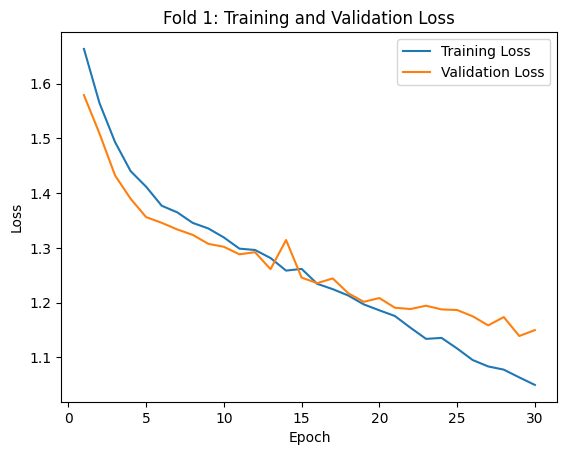

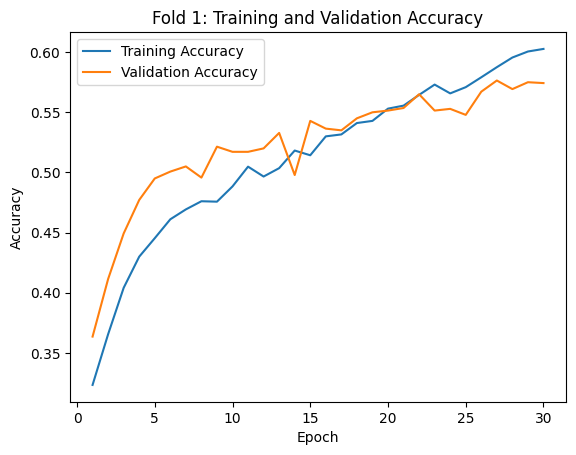

Fold 2/5
Epoch 1/30 | Training Loss: 1.6590 | Training Accuracy: 0.3184 | Training Precision: 0.5281 | Training Recall: 0.1975 | Validation Loss: 1.5871 | Validation Accuracy: 0.3507
Epoch 2/30 | Training Loss: 1.5661 | Training Accuracy: 0.3688 | Training Precision: 0.5253 | Training Recall: 0.2528 | Validation Loss: 1.5160 | Validation Accuracy: 0.3850
Epoch 3/30 | Training Loss: 1.5107 | Training Accuracy: 0.3968 | Training Precision: 0.4987 | Training Recall: 0.3306 | Validation Loss: 1.4546 | Validation Accuracy: 0.4229
Epoch 4/30 | Training Loss: 1.4406 | Training Accuracy: 0.4323 | Training Precision: 0.5274 | Training Recall: 0.3313 | Validation Loss: 1.4137 | Validation Accuracy: 0.4400
Epoch 5/30 | Training Loss: 1.4066 | Training Accuracy: 0.4534 | Training Precision: 0.5624 | Training Recall: 0.3646 | Validation Loss: 1.3644 | Validation Accuracy: 0.4771
Epoch 6/30 | Training Loss: 1.3833 | Training Accuracy: 0.4639 | Training Precision: 0.5713 | Training Recall: 0.3720 | V

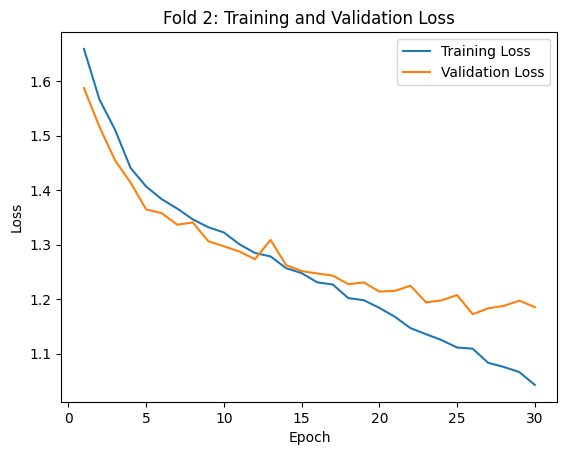

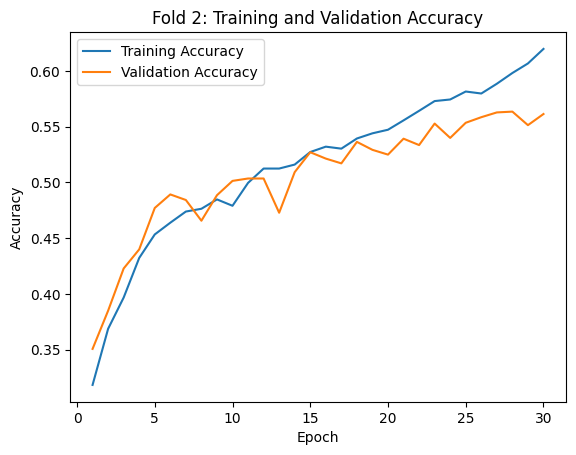

Fold 3/5
Epoch 1/30 | Training Loss: 1.6578 | Training Accuracy: 0.3225 | Training Precision: 0.4195 | Training Recall: 0.1957 | Validation Loss: 1.6047 | Validation Accuracy: 0.3457
Epoch 2/30 | Training Loss: 1.5961 | Training Accuracy: 0.3548 | Training Precision: 0.4270 | Training Recall: 0.2405 | Validation Loss: 1.5559 | Validation Accuracy: 0.3764
Epoch 3/30 | Training Loss: 1.5511 | Training Accuracy: 0.3738 | Training Precision: 0.4533 | Training Recall: 0.2715 | Validation Loss: 1.5082 | Validation Accuracy: 0.4000
Epoch 4/30 | Training Loss: 1.5053 | Training Accuracy: 0.3975 | Training Precision: 0.5039 | Training Recall: 0.2966 | Validation Loss: 1.4555 | Validation Accuracy: 0.4300
Epoch 5/30 | Training Loss: 1.4566 | Training Accuracy: 0.4241 | Training Precision: 0.5340 | Training Recall: 0.3381 | Validation Loss: 1.4123 | Validation Accuracy: 0.4671
Epoch 6/30 | Training Loss: 1.4150 | Training Accuracy: 0.4439 | Training Precision: 0.5800 | Training Recall: 0.3431 | V

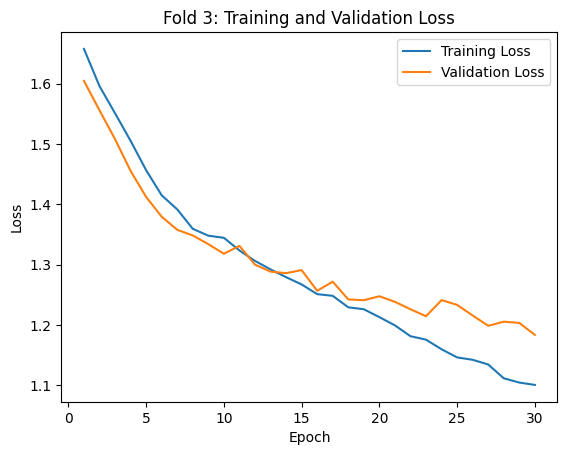

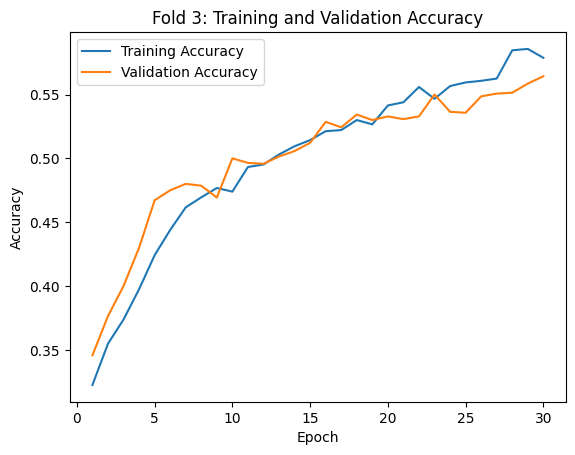

Fold 4/5
Epoch 1/30 | Training Loss: 1.6527 | Training Accuracy: 0.3196 | Training Precision: 0.4572 | Training Recall: 0.1950 | Validation Loss: 1.5998 | Validation Accuracy: 0.3286
Epoch 2/30 | Training Loss: 1.5653 | Training Accuracy: 0.3661 | Training Precision: 0.4683 | Training Recall: 0.2359 | Validation Loss: 1.5353 | Validation Accuracy: 0.3507
Epoch 3/30 | Training Loss: 1.5092 | Training Accuracy: 0.3987 | Training Precision: 0.4831 | Training Recall: 0.3135 | Validation Loss: 1.4726 | Validation Accuracy: 0.4164
Epoch 4/30 | Training Loss: 1.4605 | Training Accuracy: 0.4166 | Training Precision: 0.5330 | Training Recall: 0.3334 | Validation Loss: 1.4240 | Validation Accuracy: 0.4414
Epoch 5/30 | Training Loss: 1.4235 | Training Accuracy: 0.4402 | Training Precision: 0.5568 | Training Recall: 0.3326 | Validation Loss: 1.4074 | Validation Accuracy: 0.4329
Epoch 6/30 | Training Loss: 1.3953 | Training Accuracy: 0.4523 | Training Precision: 0.5773 | Training Recall: 0.3417 | V

/home/anujay/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


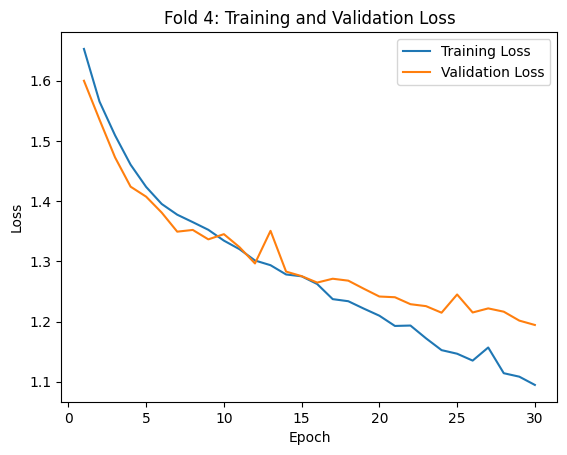

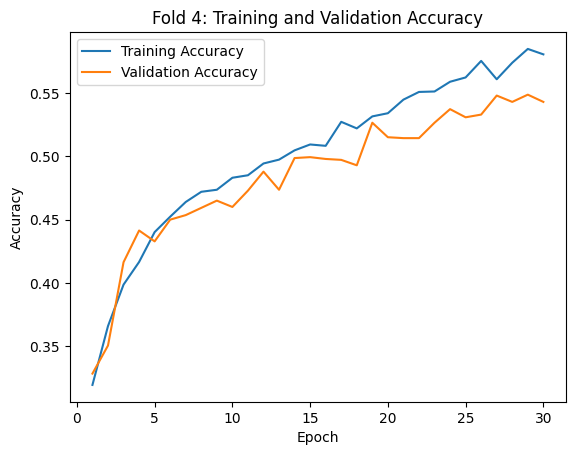

Fold 5/5
Epoch 1/30 | Training Loss: 1.6606 | Training Accuracy: 0.3146 | Training Precision: 0.5659 | Training Recall: 0.2033 | Validation Loss: 1.5804 | Validation Accuracy: 0.3586
Epoch 2/30 | Training Loss: 1.5735 | Training Accuracy: 0.3648 | Training Precision: 0.4761 | Training Recall: 0.2541 | Validation Loss: 1.5090 | Validation Accuracy: 0.3914
Epoch 3/30 | Training Loss: 1.5068 | Training Accuracy: 0.3980 | Training Precision: 0.5254 | Training Recall: 0.2741 | Validation Loss: 1.4462 | Validation Accuracy: 0.4114
Epoch 4/30 | Training Loss: 1.4483 | Training Accuracy: 0.4318 | Training Precision: 0.5304 | Training Recall: 0.3166 | Validation Loss: 1.3969 | Validation Accuracy: 0.4471
Epoch 5/30 | Training Loss: 1.4059 | Training Accuracy: 0.4575 | Training Precision: 0.5484 | Training Recall: 0.3462 | Validation Loss: 1.3610 | Validation Accuracy: 0.4836
Epoch 6/30 | Training Loss: 1.3850 | Training Accuracy: 0.4586 | Training Precision: 0.6024 | Training Recall: 0.3418 | V

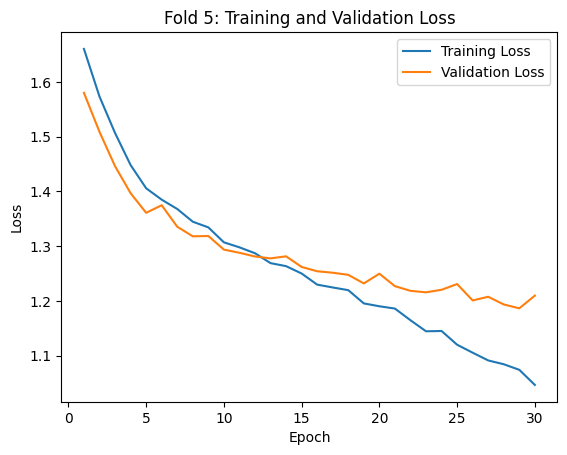

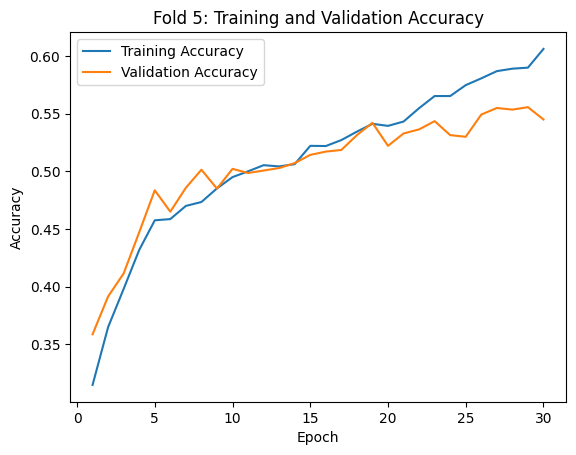

Average Metrics:
Test Accuracy: 0.5692
Test Precision: 0.5257
Test Recall: 0.4601


In [25]:
# Initialize k-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
test_accuracies = []
test_precisions = []
test_recalls = []

# Loop over the folds
for fold, (train_idx, val_idx) in enumerate(kf.split(train_files)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split data into training and validation sets for this fold
    fold_train_files = [train_files[i] for i in train_idx]
    fold_val_files = [train_files[i] for i in val_idx]
    fold_train_labels = [train_labels[i] for i in train_idx]
    fold_val_labels = [train_labels[i] for i in val_idx]

    # Create datasets and data loaders for this fold
    fold_train_dataset = CustomDataset(image_folder, fold_train_files, fold_train_labels, transform=preprocess)
    fold_val_dataset = CustomDataset(image_folder, fold_val_files, fold_val_labels, transform=preprocess)

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Reinitialize the model and optimizer for each fold
    model = Net()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=alpha, momentum=0.75)

    # Initialize lists to store metrics for both training and validation data within this fold
    fold_train_losses = []
    fold_train_accuracies = []
    fold_train_precisions = []
    fold_train_recalls = []

    fold_val_losses = []
    fold_val_accuracies = []
    fold_val_precisions = []  # Added this line
    fold_val_recalls = []  # Added this line

    best_loss = float('inf')

    # Training loop for this fold
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0.0
        total_samples = 0
        correct_predictions = 0

        for images, continents in fold_train_loader:
            images = images.to(device)
            continents = continents.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, continents)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == continents).sum().item()

        # Calculate average training loss for this epoch
        average_loss = total_loss / total_samples
        fold_train_losses.append(average_loss)

        # Calculate training accuracy for this epoch
        train_accuracy = correct_predictions / total_samples
        fold_train_accuracies.append(train_accuracy)

        # Calculate training precision and recall for this epoch
        train_preds = []
        train_targets = []

        with torch.no_grad():
            for images, continents in fold_train_loader:
                images = images.to(device)
                continents = continents.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                train_preds.extend(predicted.cpu().numpy())
                train_targets.extend(continents.cpu().numpy())

        train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_targets, train_preds, average='macro')
        fold_train_precisions.append(train_precision)
        fold_train_recalls.append(train_recall)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for images, continents in fold_val_loader:
                images = images.to(device)
                continents = continents.to(device)

                outputs = model(images)
                loss = criterion(outputs, continents)

                val_loss += loss.item() * images.size(0)
                val_total_samples += images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == continents).sum().item()

        # Calculate average validation loss for this epoch
        average_val_loss = val_loss / val_total_samples
        fold_val_losses.append(average_val_loss)

        # Calculate validation accuracy for this epoch
        val_accuracy = val_correct_predictions / val_total_samples
        fold_val_accuracies.append(val_accuracy)

        # Print training and validation progress for each epoch
        print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {average_loss:.4f} | Training Accuracy: {train_accuracy:.4f} | Training Precision: {train_precision:.4f} | Training Recall: {train_recall:.4f} | Validation Loss: {average_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            torch.save(model.state_dict(), "best_model.pt")

    # Load the best model state for this fold based on validation loss
    best_model_state = torch.load("best_model.pt")
    model.load_state_dict(best_model_state)

    # Evaluate on test data for this fold
    model.eval()
    test_probs = []
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for images, continents in test_loader:
            images = images.to(device)
            continents = continents.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of the positive class (continent = 1)
            _, predicted = torch.max(outputs, 1)

            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(continents.cpu().numpy())

    # Calculate and store evaluation metrics for this fold
    test_accuracy = accuracy_score(test_targets, test_preds)
    test_precision = precision_score(test_targets, test_preds, average='macro')
    test_recall = recall_score(test_targets, test_preds, average='macro')

    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)

    # Plot training and validation losses for this fold
    plt.figure()
    plt.plot(range(1, num_epochs + 1), fold_train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), fold_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1}: Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies for this fold
    plt.figure()
    plt.plot(range(1, num_epochs + 1), fold_train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), fold_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold + 1}: Training and Validation Accuracy')
    plt.legend()
    plt.show()
# Calculate and print the average evaluation metrics across all folds
print("Average Metrics:")
print(f"Test Accuracy: {sum(test_accuracies) / num_folds:.4f}")
print(f"Test Precision: {sum(test_precisions) / num_folds:.4f}")
print(f"Test Recall: {sum(test_recalls) / num_folds:.4f}")

In [26]:
# # Initialize the best loss with a high value
# best_loss = float('inf')

# # Training loop
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     total_loss = 0.0
#     total_samples = 0
#     correct_predictions = 0

#     for images, continents in train_loader:
#         images = images.to(device)
#         continents = continents.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, continents)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * images.size(0)
#         total_samples += images.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == continents).sum().item()

#     # Calculate average training loss for this epoch
#     average_loss = total_loss / total_samples
#     train_losses.append(average_loss)

#     # Calculate training accuracy for this epoch
#     train_accuracy = correct_predictions / total_samples
#     train_accuracies.append(train_accuracy)

#     # Calculate training precision and recall for this epoch
#     train_preds = []
#     train_targets = []

#     with torch.no_grad():
#         for images, continents in train_loader:
#             images = images.to(device)
#             continents = continents.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             train_preds.extend(predicted.cpu().numpy())  # Convert predictions to numpy array and store
#             train_targets.extend(continents.cpu().numpy())  # Convert true labels to numpy array and store

#     # Set zero_division parameter to handle ill-defined precision
#     train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=1)
#     train_recall = recall_score(train_targets, train_preds, average='macro')
#     train_precisions.append(train_precision)
#     train_recalls.append(train_recall)

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     val_correct_predictions = 0
#     val_total_samples = 0

#     with torch.no_grad():
#         for images, continents in val_loader:
#             images = images.to(device)
#             continents = continents.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, continents)

#             val_loss += loss.item() * images.size(0)
#             val_total_samples += images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             val_correct_predictions += (predicted == continents).sum().item()

#     # Calculate average validation loss for this epoch
#     average_val_loss = val_loss / val_total_samples
#     val_losses.append(average_val_loss)

#     # Calculate validation accuracy for this epoch
#     val_accuracy = val_correct_predictions / val_total_samples
#     val_accuracies.append(val_accuracy)

#     # Print training and validation progress
#     print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {average_loss:.4f} | Training Accuracy: {train_accuracy:.4f} | Training Precision: {train_precision:.4f} | Training Recall: {train_recall:.4f} | Validation Loss: {average_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

#     # Save the best model based on validation loss
#     if average_val_loss < best_loss:
#         best_loss = average_val_loss
#         torch.save(model.state_dict(), "best_model.pt")

In [27]:
# Evaluation on Test data
# Load the best model state
best_model_state = torch.load("best_model.pt")
model.load_state_dict(best_model_state)

# Evaluate on test data
model.eval()
test_probs = []
test_preds = []
test_targets = []

with torch.no_grad():
    for images, continents in test_loader:
        images = images.to(device)
        continents = continents.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of the positive class (continent = 1)
        _, predicted = torch.max(outputs, 1)

        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(continents.cpu().numpy())

# Calculate and print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(test_targets, test_preds))

# Calculate and print test accuracy, precision, and recall
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='macro')
test_recall = recall_score(test_targets, test_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.4f} | Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       208
           1       0.56      0.69      0.62       463
           2       0.45      0.22      0.29       204
           3       0.75      0.55      0.64       236
           4       0.51      0.77      0.62       324
           5       0.50      0.02      0.03        65

    accuracy                           0.57      1500
   macro avg       0.57      0.46      0.46      1500
weighted avg       0.58      0.57      0.55      1500

Test Accuracy: 0.5700 | Test Precision: 0.5709 | Test Recall: 0.4623


In [28]:
# Plot training loss
plt.figure()
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

# Plot training accuracy
plt.figure()
sns.lineplot(x=range(1, num_epochs + 1), y=train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy')
plt.show()

# Plot training precision
plt.figure()
sns.lineplot(x=range(1, num_epochs + 1), y=train_precisions)
plt.xlabel('Epoch')
plt.ylabel('Training Precision')
plt.title('Training Precision')
plt.show()

# Plot training recall
plt.figure()
sns.lineplot(x=range(1, num_epochs + 1), y=train_recalls)
plt.xlabel('Epoch')
plt.ylabel('Training Recall')
plt.title('Training Recall')
plt.show()

# Plot training and validation losses
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

ValueError: All arrays must be of the same length

<Figure size 640x480 with 0 Axes>